In [25]:
# IT24101966

# Import libraries
import pandas as pd
import numpy as np
import os
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import joblib
import warnings

# Mount google drive
drive.mount('/content/drive')

# Set folders to save results
results_path = '/content/drive/My Drive/results/'
model_path = results_path + 'models/'
vis_path = results_path + 'dt_visualizations/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Load dataset
final_path = results_path + "final_preprocessed_dataset.csv"
df = pd.read_csv(final_path)

# Split into features and target
X = df.drop(columns=["Target"])
y = df["Target"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (5036, 10)
Testing shape: (1259, 10)


In [27]:
# Set up decision tree and parameters

# Create decision tree model
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters
param_grid = {
'criterion': ['gini', 'entropy'],      # Split quality
'max_depth': [None, 5, 10, 15],        # Max tree depth
'min_samples_split': [2, 5, 10],       # Min samples to split
'min_samples_leaf': [1, 2, 4]          # Min samples per leaf
}

In [28]:

# Hyperparameter tuning using grid search


# Set up 5-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up grid search to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit gridSearch on training data
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Cross-Validation Accuracy: 0.7208


In [29]:

#  test model on the test data set
y_pred = best_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print(f" Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Show detailed classification report
print("Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=['Dropout', 'Enrolled', 'Graduate']
))


 Test Accuracy: 0.7292
Precision: 0.7375, Recall: 0.7292, F1 Score: 0.7309
Classification Report:
              precision    recall  f1-score   support

     Dropout       0.77      0.69      0.73       411
    Enrolled       0.64      0.74      0.69       431
    Graduate       0.81      0.75      0.78       417

    accuracy                           0.73      1259
   macro avg       0.74      0.73      0.73      1259
weighted avg       0.74      0.73      0.73      1259



Text(45.722222222222214, 0.5, 'Actual')

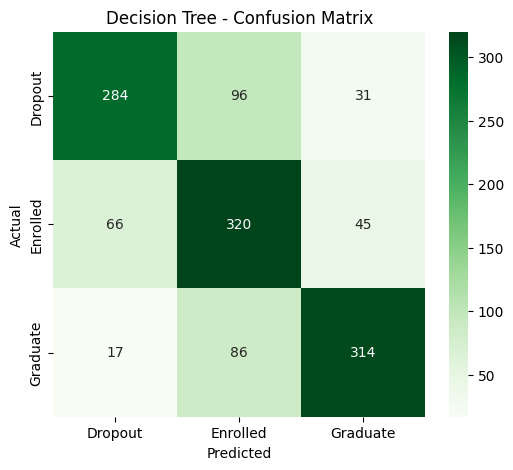

In [30]:
# confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Dropout', 'Enrolled', 'Graduate'],
    yticklabels=['Dropout', 'Enrolled', 'Graduate']
)
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')


In [33]:

# Compare different decision tree variations


# Define three decision Tree versions
models = {
    "Default (gini, full depth)": DecisionTreeClassifier(criterion='gini', random_state=42),
    "Limited depth (entropy, depth=5)": DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42),
    "Pruned (gini, leaf=4)": DecisionTreeClassifier(criterion='gini', min_samples_leaf=4, random_state=42)
}

# Store results
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_var = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_var)
    f1s = f1_score(y_test, y_pred_var, average='weighted')
    results.append([name, acc, f1s])

# Show comparison in a data frame
comparison = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])
print(comparison)


                              Model  Accuracy  F1 Score
0        Default (gini, full depth)  0.719619  0.719663
1  Limited depth (entropy, depth=5)  0.722796  0.725032
2             Pruned (gini, leaf=4)  0.728356  0.728778


In [34]:
# Cross validation and Save Model

# Perform 5 fold cross validation on the full dataset
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Final Cross-Validation Accuracy: {cv_scores.mean():.4f}")

# Save the trained Decision Tree model
model_file = model_path + 'decision_tree_model.pkl'
joblib.dump(best_model, model_file)

# Save a summary of the model results
summary = pd.DataFrame({
    "Best Params": [str(best_params)],
    "Test Accuracy": [accuracy],
    "CV Mean": [cv_scores.mean()],
    "CV Std": [cv_scores.std()]
})
summary_file = results_path + "dt_results_summary.csv"
summary.to_csv(summary_file, index=False)

Final Cross-Validation Accuracy: 0.7236
